# Decoding cell identity based on kinetic parameters of pancreatic endocrinogenesis data

This tutorial shows how to decode cell identity based on kinetic parameters using the predicted pancreatic endocrinogenesis data.

For the pre-processing, by following the study of [Bergen et.al](https://www.nature.com/articles/s41587-020-0591-3), 3,696 cells with 2,000 genes are selected.

## Import Packages

To run the notebook locally, create a conda environment as ```conda env create -n cellDancer python==3.7.6```, then install the dependencies by ```pip install -r requirements.txt``` using this [requirememts.txt](requirememts.txt).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import random
import sys
import pandas as pd
import math
import matplotlib.pyplot as plt

# import from absolute directory
#srcdir = '/Users/pengzhizhang/cellDancer/src'
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'
# srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
# srcdir = '/Users/chen.weiqing/Documents/GitHub/cellDancer/src'
sys.path.append(srcdir)
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
from celldancer.velocity_estimation import velocity
from celldancer.compute_cell_velocity import compute
from celldancer.pseudo_time import pseudo_time
from celldancer.embedding_kinetic_para import embedding

## Load the velocity estimation result of all 2159 genes in pancreatic endocrinogenesis data

Let’s visualize the visualize the predicted results pf each gene with ```celldancer.cdplt.gene.scatter_gene()```

In [ ]:
import pandas as pd
import celldancer as cd

cell_type_u_s=pd.read_csv('PancreaticEndocrinogenesis.csv')
loss_df, cellDancer_df=cd.velocity_estimation.velocity(cell_type_u_s, permutation_ratio=0.5, n_jobs=8)

The predicted result ```cellDancer_df``` was saved to [PancreaticEndocrinogenesis_cellDancer_estimation.csv](xxx). It could be downloaded online and loaded with ```pd.read_csv('your_path/PancreaticEndocrinogenesis_cellDancer_estimation.csv')```. 

In [2]:
#detail_result_path = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/pancreas/velocity_result/velocity_result_all_genes_with_bin/2000_smooth/combined_detail/combined_detail.csv'
#cellDancer_df_path = '/Users/wanglab/Documents/ShengyuLi/Velocity/data/pancreas/velocity_result/2000_smooth/velocity_result_all_genes_with_bin/combined_detail/combined_detail.csv'
cellDancer_df_path = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/pancreas/velocity_result/fin_parameter_0529/cell_dancer_velocity_2022-05-28 19-03-50/celldancer_estimation.csv'
#detail_result_path = '/Users/chen.weiqing/code/celldancer/pancreas/combined_detail.csv'

cellDancer_df=pd.read_csv(cellDancer_df_path)
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Scaper,0.489151,0.211323,0.486841,0.185478,0.334391,0.629880,0.647696,0.043435,AAACCTGAGAGGGATA,Pre-endocrine,6.143066,-0.063644
1,1,Scaper,0.278262,0.125742,0.293904,0.107517,0.224909,0.626946,0.648537,0.043435,AAACCTGAGCCTTGAT,Ductal,-9.906417,0.197778
2,2,Scaper,0.374380,0.298116,0.348888,0.197525,0.213979,0.648890,0.665279,0.043435,AAACCTGAGGCAATTA,Alpha,7.559791,0.583762
3,3,Scaper,0.320497,0.198031,0.318165,0.146120,0.219611,0.636208,0.655523,0.043435,AAACCTGCATCATCCC,Ductal,-11.283765,4.218998
4,4,Scaper,0.239145,0.141970,0.251417,0.106599,0.192050,0.631560,0.652837,0.043435,AAACCTGGTAAGTGGC,Ngn3 high EP,1.721565,-4.753407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391995,3691,Tmem63a,0.000000,0.136270,0.000447,0.125414,0.005472,0.110095,0.067564,0.045492,TTTGTCAAGTGACATA,Pre-endocrine,4.768472,-1.388353
7391996,3692,Tmem63a,0.028708,0.000000,0.021286,0.022931,0.017270,0.100517,0.072741,0.045492,TTTGTCAAGTGTGGCA,Ngn3 high EP,-1.873335,-4.182650
7391997,3693,Tmem63a,0.000000,0.312690,0.000200,0.288797,0.002445,0.116196,0.064809,0.045492,TTTGTCAGTTGTTTGG,Ductal,-9.882250,-0.105594
7391998,3694,Tmem63a,0.028052,0.154164,0.019519,0.165354,0.008143,0.107124,0.069812,0.045492,TTTGTCATCGAATGCT,Alpha,6.612424,4.531895


## Compute Cell Velocity

(genes, cells): (2000, 3696)
After downsampling, there are  845 cells.


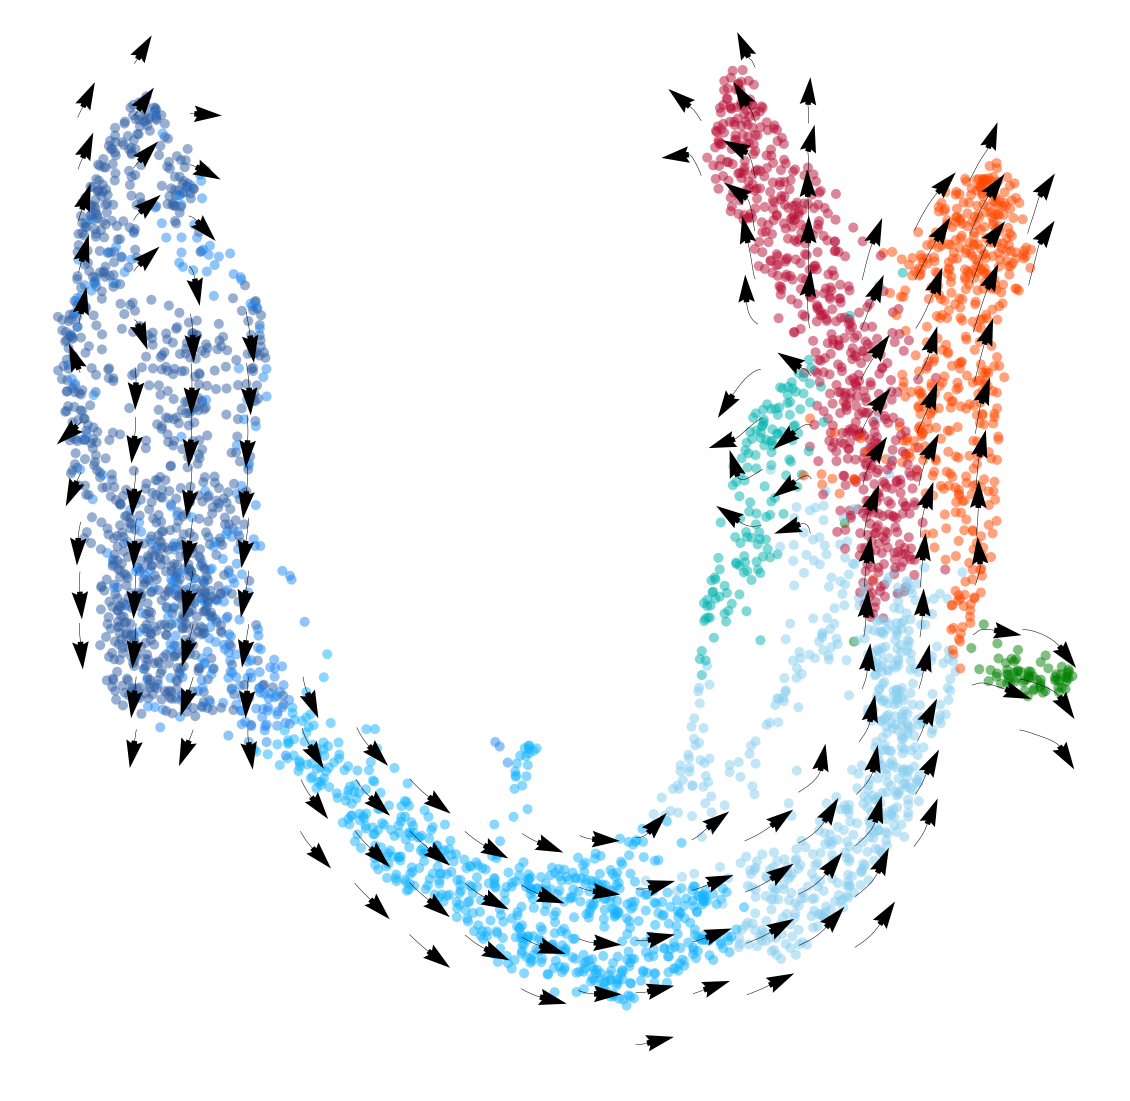

In [11]:
%autoreload 2

# set parameters
projection_neighbor_choice='embedding'
expression_scale=None
projection_neighbor_size=100
speed_up=(60,60)

arrow_grid=(20,20)
dt = 0.01
t_total = 10000
n_repeats = 10

# compute cell velocity
cellDancer_df=compute(cellDancer_df=cellDancer_df,
              projection_neighbor_choice=projection_neighbor_choice,
              expression_scale=expression_scale,
              projection_neighbor_size=projection_neighbor_size,
              speed_up=speed_up)

# plot cell velocity
fig, ax = plt.subplots(figsize=(20,20))
clusters = cellDancer_df['clusters'].drop_duplicates().to_list()
cdplt.cell.scatter_cell(ax,
                        cellDancer_df, 
                        colors=cdplt.colormap.colormap_pancreas, 
                        alpha=0.5, 
                        s=100,
                        velocity=True,
                        arrow_grid=arrow_grid,
                       min_mass=5)
ax.axis('off')
plt.show()

In [10]:
%autoreload 2

cell_time = dict()
dt = 0.01
#t_total = {dt:int(10/dt)} 
t_total = {0.01: 1000}
n_repeats = 10

grid = (20,20)

load_cellDancer = pseudo_time(
    load_cellDancer=cellDancer_df, 
    grid=grid, 
    dt=dt, 
    t_total=t_total[dt], 
    n_repeats=n_repeats, 
    downsample_step=downsample_step,
    n_paths = 3,
    psrng_seeds_diffusion=[i for i in range(n_repeats)],
    activate_umap_paths_divider=False,
    n_jobs=12)

NameError: name 'downsample_step' is not defined

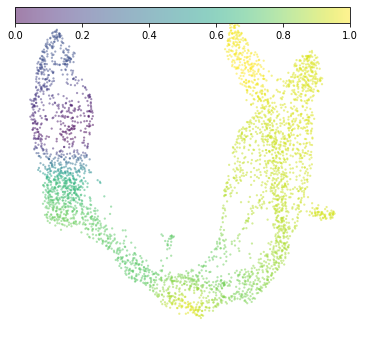

In [138]:
fig, ax = plt.subplots(figsize=(6,6))
clusters = cellDancer_df['clusters'].drop_duplicates().to_list()
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, 
             velocity=False)
ax.axis('off')
plt.show()

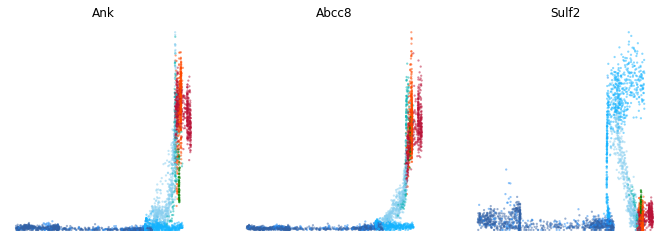

In [144]:
import math
ncols=5
fig = plt.figure(figsize=(20,4))


for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='spliced',
        cellDancer_df=cellDancer_df,
        save_path=None,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_pancreas,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

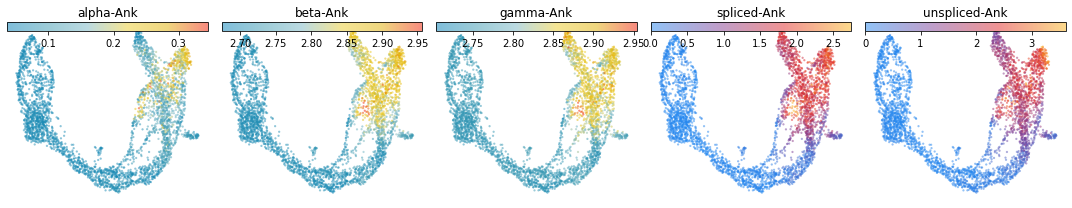

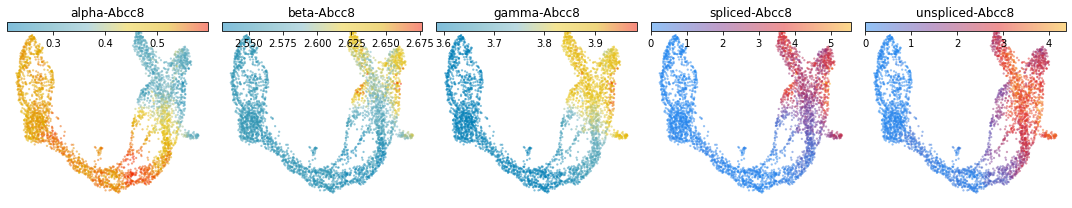

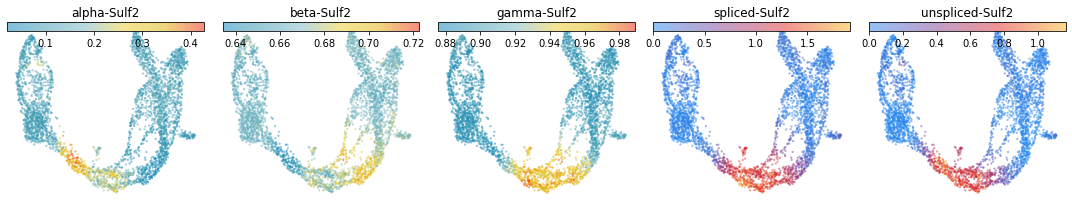

In [117]:
%autoreload 2


for gene in gene_list[0:3]:
    fig, ax = plt.subplots(ncols=5, figsize=(15,3))
    cdplt.cell.scatter_cell(ax[0],cellDancer_df, colors='alpha', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[1],cellDancer_df, colors='beta', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[2],cellDancer_df, colors='gamma', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[3],cellDancer_df, colors='spliced', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[4],cellDancer_df, colors='unspliced', 
                 gene=gene, velocity=False)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    ax[0].set_title('alpha-'+gene)
    ax[1].set_title('beta-'+gene)
    ax[2].set_title('gamma-'+gene)
    ax[3].set_title('spliced-'+gene)
    ax[4].set_title('unspliced-'+gene)
    plt.tight_layout()
    plt.show()

## UMAP using alpha, beta, and gamma

In [108]:
cellDancer_df=embedding(cellDancer_df,'alpha')
cellDancer_df=embedding(cellDancer_df,'beta')
cellDancer_df=embedding(cellDancer_df,'gamma')
cellDancer_df=embedding(cellDancer_df,'alpha_beta_gamma')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


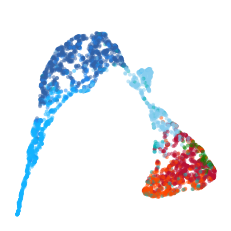

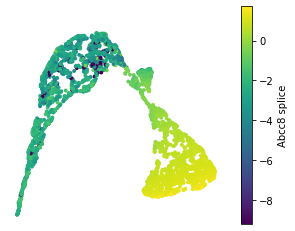

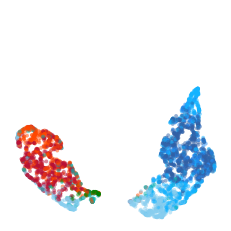

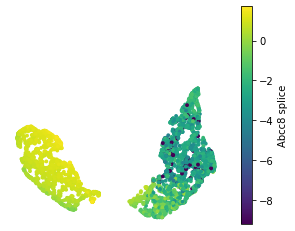

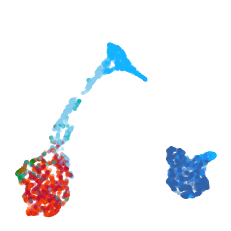

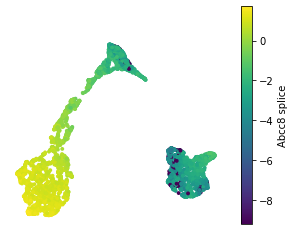

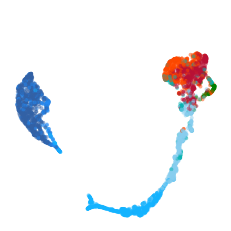

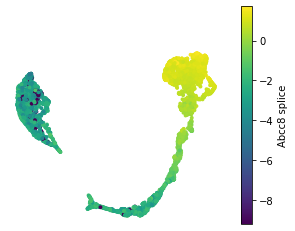

In [116]:
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,gene='Abcc8',color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,gene='Abcc8',color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,gene='Abcc8',color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,gene='Abcc8',color_map=cdplt.colormap.colormap_pancreas ,save_path=None,title=None)